# GeoNet FDSN webservice with rFDSN to do Date Select

This tutorial assumes that you have R and basic knolage of R. We will be using using a package called IRISSeismic (https://CRAN.R-project.org/package=IRISSeismic) if you have not all realy used this you will need to run the code below. Note this code might tack some time to run but you only need to run this once.

In [1]:
install.packages("IRISSeismic")

Warning message:
"unable to access index for repository http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5:
  cannot open URL 'http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/3.5/PACKAGES'"

package 'IRISSeismic' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jlowe\AppData\Local\Temp\Rtmp2Jdrif\downloaded_packages


###### GeoNet has two FDSN wave servers
    An archive server holds verified data starting 7days after collection
    A near real-time servers holds unverified data from the last 8 days

Frist inport your library and set your urls

In [2]:
library(IRISSeismic)
#Near real time
nrt <- new('IrisClient', site = 'https://service-nrt.geonet.org.nz')
#Archive
acr <- new('IrisClient', site = 'https://service.geonet.org.nz')

Then set your paramters where the start and end time is in UTC (Universtal Time Coordinated) which is 13 or 12 hours behind nzt(New Zealand Time) (depending on daylight savings time). There are online converters such as https://savvytime.com/converter/utc-to-nzst. Put the UTC into the code.

In [3]:
starttime <- as.POSIXct("2016-11-13 11:02:30.000",tz="GMT")
endtime <- starttime + 800

I want to know what station there are to get data from in all of the archive so I know where to start looking.

In [4]:
all_station <- getStation(acr,"NZ", "*","*", "*",starttime ,endtime)
dim(all_station)

[1] 519   8

This says there are 519 stastion on the network. Too many know where to strat, but I know the place I want to look at in latitude and longitude coordinates. With this and radius of how far I'm willing to look I can find some station to get data for.

In [5]:
getStation(acr,"NZ", "*","*", "*",starttime ,endtime, latitude= -41.7, longitude=172.9,maxradius =0.1)

network,station,latitude,longitude,elevation,sitename,starttime,endtime
NZ,KLDS,-41.67309,172.8750,494,Kikiwa Line Depot,2002-02-27,NA
NZ,THZ,-41.76247,172.9052,747,Top House,1989-12-02,NA


We put the data into the quary in the form network, station, location, channel, starttime, and endtime. In the example belowe we are using the Top House station I also know I want to look at the east west channel. When I don't know the name I can put in (?)

Then get this data from the server by trying both the nrt server and the acr server, this may take some time if you are trying to got a lot of data.

In [6]:
try(arc_data <- getDataselect(acr,"NZ", "THZ","*", "HHE",starttime ,endtime, ignoreEpoch=TRUE))
try(nrt_data <- getDataselect(nrt,"NZ", "THZ","*", "HHE",starttime ,endtime, ignoreEpoch=TRUE))

We can then merge the data for the 2 servers

In [7]:
try(st <- arc_data)
try(st <- nrt_data)
try(st <- mergeUpDownTimes(arc_data,nrt_data, fillZero))

I want to find out so more info about my data by looking at the metadata data of my miniSEED, I can do this by printing out my data

In [8]:
tr <- st@traces[[1]]#tack the trace out of the stream. in this case we only have one
print("stats:")
slot(tr, "stats")
print("Sensor type:")
slot(tr,"Sensor")
print("Instrument Sensitivity:")
slot(tr,"InstrumentSensitivity")
print("Sensitivity Frequency:")
slot(tr,"SensitivityFrequency")
print("Input Units:")
slot(tr,"InputUnits")

[1] "stats:"


Seismic Trace TraceHeader 
 Network:        NZ 
 Station:        THZ 
 Location:       10 
 Channel:        HHE 
 Quality:        D 
 calib:          1 
 npts:           80575 
 sampling rate:  100 
 delta:          0.01 
 starttime:      2016-11-13 11:02:25 
 endtime:        2016-11-13 11:15:51 
 latitude:       -41.76247 
 longitude:      172.9052 
 elevation:      747 
 depth:          0 
 azimuth:        90 
 dip:            0 
 processing:      

[1] "Sensor type:"


[1] "Broadband Seismometer"

[1] "Instrument Sensitivity:"


[1] 838860800

[1] "Sensitivity Frequency:"


[1] 1

[1] "Input Units:"


[1] "m/s"

I want to cheek if the data I have is complet and has not gaps. 

In [9]:
getGaps(st)

$gaps
[1] 0 0

$nsamples
[1] 0 0

This data has no gaps.

I also what to print out some basic stats

In [10]:
print("number of smaple in data:")
length(tr)
print("max data point:")
max(tr)
print("mean of data:")
mean(tr)
print("standard deviation of data:")
sd(tr)
print("root mean square of data:")
rms(tr)
print("root mean square variance of data:")
rmsVariance(tr)

[1] "number of smaple in data:"


[1] 80575

[1] "max data point:"


[1] 8708872

[1] "mean of data:"


[1] 8616.31

[1] "standard deviation of data:"


[1] 2537938

[1] "root mean square of data:"


[1] 2537937

[1] "root mean square variance of data:"


[1] 2537922

We can then plot the data 

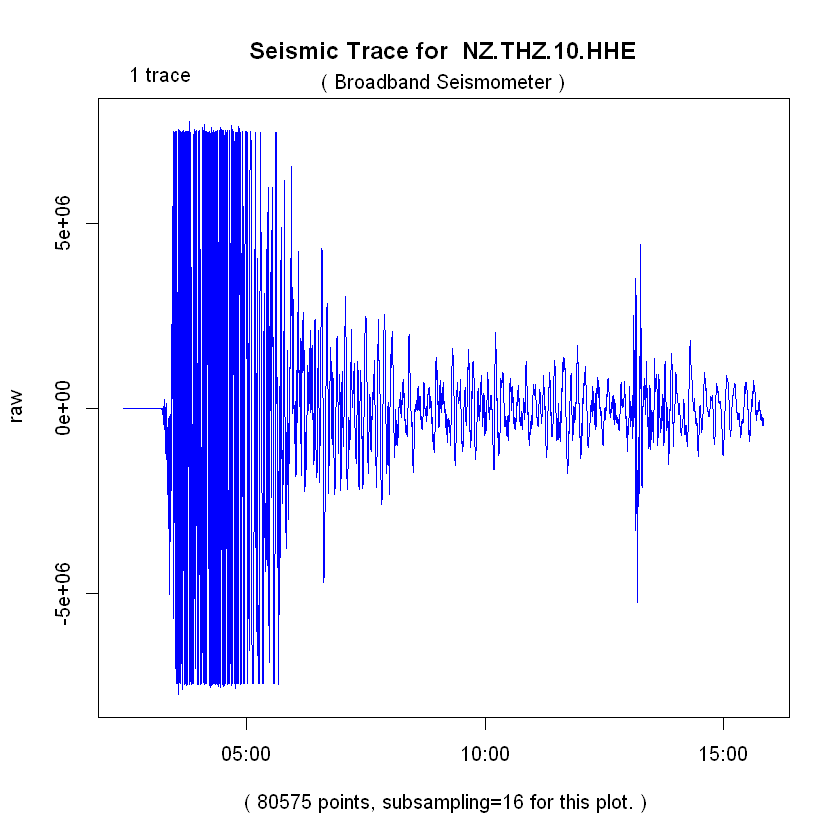

In [11]:
plot(st, col  = "blue")

Now that I've Seen the plot I want to see only the frist 1/2 of the data in a plot.

In [12]:
newtime <- endtime - 400
st_slice <- slice(st, starttime, newtime)

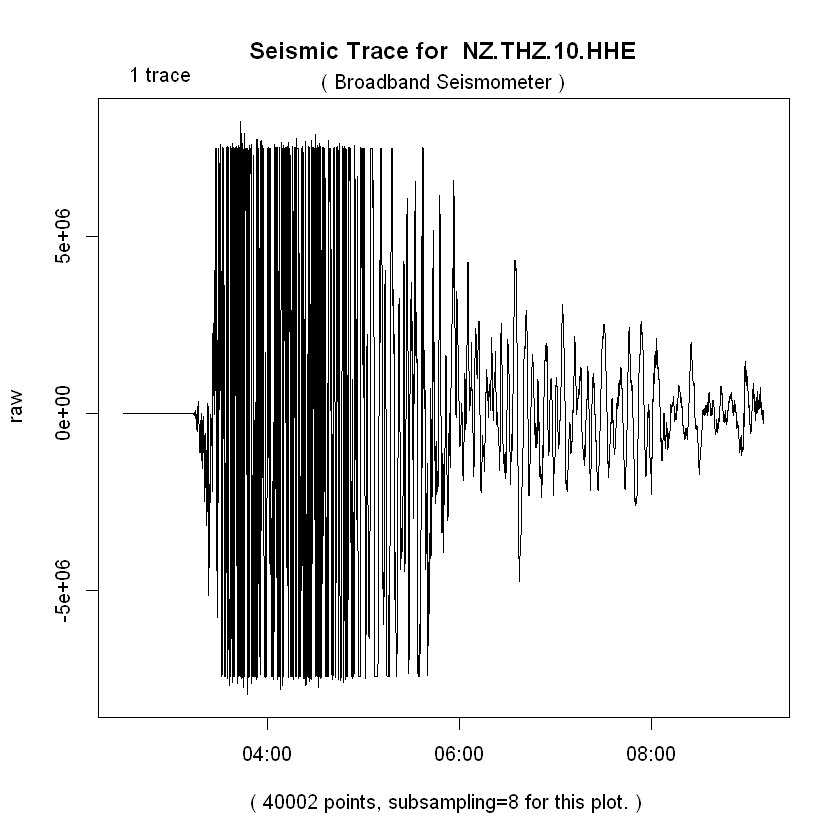

In [13]:
plot(st_slice)

Now I want to save my data as csv so I can deal with it in outher progams

In [14]:
raw_data <- slot(tr,"data")
save(raw_data, file = "raw_data.csv", ascii = TRUE)

IRISSeismic has alot of fuction that could be usefull. Ducumation of then with exampls can be found at https://cran.r-project.org/web/packages/IRISSeismic/IRISSeismic.pdf